In [1]:
!aws s3 sync s3://rowerki ./data

download: s3://rowerki/1654460694.csv to data/1654460694.csv        
download: s3://rowerki/1654460094.csv to data/1654460094.csv        
download: s3://rowerki/1654458893.csv to data/1654458893.csv        
download: s3://rowerki/1654459494.csv to data/1654459494.csv        


In [2]:
# univariate multi-step encoder-decoder convlstm
import sys, os
sys.path.append('..')
import utils
import numpy as np
import pandas as pd 
import json
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta  
from sklearn.metrics import mean_squared_error 
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, RepeatVector, TimeDistributed, ConvLSTM2D

In [3]:
stations = utils.get_stations()
stations = stations[stations['place_type'] != '14'] .reset_index(drop=True)
#exclude electric stations, which are frequently very close to normal stations 
stations ['row'] = 0
stations ['col'] = 0
config = json.load(open('../config.json'))
bounding_rectangle = [[min(stations['lat']),max(stations['lat']) + config['bounding_frame_eps']], 
                      [min(stations['lng']),max(stations['lng'])  + config['bounding_frame_eps']]]
widths = [dimension[1] - dimension[0] for dimension in bounding_rectangle]
number_of_divisions = config['number_of_divisions']
for col in range(number_of_divisions): 
    for row in range(number_of_divisions): 
        station_in_rectangle = (stations['lat']>= (row)*widths[0]/number_of_divisions + bounding_rectangle[0][0]) &\
        (stations['lat']< (row+1)*widths[0]/number_of_divisions + bounding_rectangle[0][0]) &\
        (stations['lng']>= (col)*widths[1]/number_of_divisions + bounding_rectangle[1][0]) &\
        (stations['lng']< (col+1)*widths[1]/number_of_divisions + bounding_rectangle[1][0])
        if sum(station_in_rectangle) >1:
            raise(Exception("More than 1 station"))   
        if sum(station_in_rectangle) ==1:
            stations.loc[station_in_rectangle, ["row", "col"]] = [number_of_divisions - row - 1, col]

In [4]:
for _ in range(3): #downsampling 3 times
    stations[["row", "col"]]=stations[["row", "col"]]//2
    while not stations[["row", "col"]].duplicated().any():
        stations[["row", "col"]] += stations[["row", "col"]].groupby(["row", "col"]).cumcount()
stations = stations.reset_index()

In [5]:
bikes = utils.read_bikes()
bikes = bikes[bikes["date"].dt.minute == bikes["date"].dt.minute.max()] #downsampling - last obs in given hour
grouped = utils.rented_returned_amount(bikes, stations)
# del bikes 
grouped 

,date,station_id,bike_count,just_returned,just_rented,index,uid,lat,lng,name,bike_racks,place_type,row,col
0,2022-05-08 18:54:00,448565,5,5,0.0,306,448565,52.183992,21.009840,Nestle House,15,0,27,21
1,2022-05-08 19:54:00,448565,5,3,3.0,306,448565,52.183992,21.009840,Nestle House,15,0,27,21
2,2022-05-08 20:54:00,448565,5,1,1.0,306,448565,52.183992,21.009840,Nestle House,15,0,27,21
3,2022-05-08 21:54:00,448565,6,1,0.0,306,448565,52.183992,21.009840,Nestle House,15,0,27,21
4,2022-05-08 22:54:00,448565,6,0,0.0,306,448565,52.183992,21.009840,Nestle House,15,0,27,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222376,2022-06-05 05:54:00,8746360,1,1,1.0,328,8746360,52.181135,20.992429,Marynarska 12,20,0,27,18
222377,2022-06-05 06:54:00,8746360,1,0,0.0,328,8746360,52.181135,20.992429,Marynarska 12,20,0,27,18
222378,2022-06-05 07:54:00,8746360,1,0,0.0,328,8746360,52.181135,20.992429,Marynarska 12,20,0,27,18
222379,2022-06-05 08:54:00,8746360,1,1,1.0,328,8746360,52.181135,20.992429,Marynarska 12,20,0,27,18


In [6]:
def date_stats(dt):
    dt = pd.to_datetime(dt)
    return (dt.hour, dt.weekday(), dt.month)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


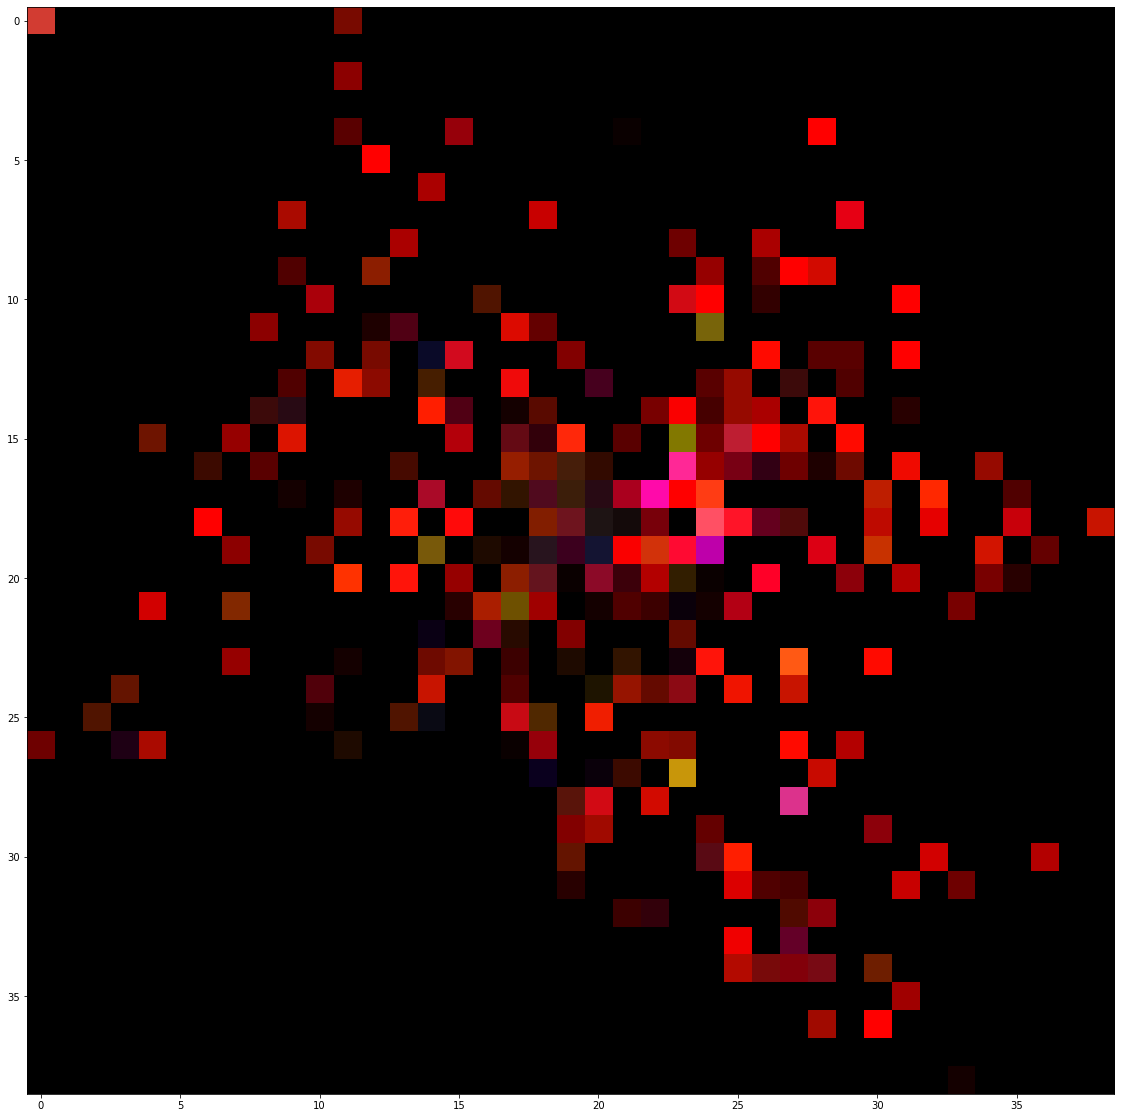

In [7]:
imgs = {}
for dt in grouped['date'].unique(): 
    img = np.zeros([max(stations['row'])+1, max(stations['col'])+1, 3])
    for stats in grouped[grouped['date'] == dt].to_dict('records'):
        img[stats['row'], stats['col'], :] = [stats["bike_count"],stats["just_returned"],stats["just_rented"]]
    img[0, 0, : ] = date_stats(dt) # encode date in first pixel
    imgs[dt] = img/255
plt.figure(figsize=(20,20))
plt.imshow(list(imgs.values())[3]*10)

In [8]:
train, test = [], []
for day, image in sorted(imgs.items(), key=lambda x: x[0]):
    day = pd.to_datetime(day)
    if (day >= datetime.now() - timedelta(days=31)) and (day <= datetime.now() - timedelta(days=10)):
        train.append(image)
    if (day >= datetime.now() - timedelta(days=10)):
        test.append(image)
# del imgs
train = np.array(train)
test = np.array(test)
train.shape

(434, 39, 39, 3)

In [9]:
def img_to_vect(img):
    result = np.zeros(len(stations)*3)
    for index, row, col in stations[["index", "row", "col"]].values.tolist():
        result[[3*index, 3*index+1, 3*index+2]] = img[row, col, :]
    return result

In [11]:
# convert history into inputs and outputs
def to_supervised(data, n_input=24*4, n_out=24): 
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(data.shape[0]):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, :] 
            X.append(x_input)
            y.append(img_to_vect(data[out_end, :]))
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)
X_train, y_train = to_supervised(train) 
X_train.shape

(314, 96, 39, 39, 3)

In [12]:
y_train.shape

(314, 1017)

In [13]:
X_train = np.nan_to_num(X_train, copy=True, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, copy=True, nan=0.0, posinf=0.0, neginf=0.0)

In [15]:
verbose, epochs, batch_size = 1, 5, 16     
model = Sequential()
model.add(ConvLSTM2D(filters=12, 
                     kernel_size=(4,4),  
                     activation='relu', 
                     input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(RepeatVector(1))
model.add(LSTM(y_train.shape[-1]*2, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(y_train.shape[-1]*2, activation='relu')))
model.add(TimeDistributed(Dense(y_train.shape[-1], activation='relu')))
model.compile(loss='mse', optimizer='adam')
# fit network
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/5
20/20 [==============================] - 321s 16s/step - loss: 7.3317e-04
Epoch 2/5
20/20 [==============================] - 308s 15s/step - loss: 4.8915e-04
Epoch 3/5
20/20 [==============================] - 307s 15s/step - loss: 4.7446e-04
Epoch 4/5
20/20 [==============================] - 305s 15s/step - loss: 4.7185e-04
Epoch 5/5
20/20 [==============================] - 329s 16s/step - loss: 4.7094e-04


In [16]:
X_test, y_test = to_supervised(test)
X_test.shape

(120, 96, 39, 39, 3)

In [17]:
y_pred = model.predict(X_test)

4/4 [==============================] - 6s 1s/step


In [18]:
y_test.shape, y_pred.shape

((120, 1017), (120, 1, 1017))

In [19]:
y_test=y_test.reshape((y_test.shape[0], y_test.shape[1]//3, 3))*255
y_pred=y_pred.reshape((y_pred.shape[0], y_pred.shape[2]//3, 3))*255

In [20]:
print("MSE bike count: ", mean_squared_error(y_test[:,:, 0], y_pred[:,:, 0]))
print("MSE just returned count: ", mean_squared_error(y_test[:,:, 1], y_pred[:,:, 1]))
print("MSE just rented count: ", mean_squared_error(y_test[:,:, 2], y_pred[:,:, 2]))

MSE bike count:  91.88374494643311
MSE just returned count:  8.77624869776807
MSE just rented count:  8.7295051746286


In [30]:
p = stations[stations['name']=='Stefana Banacha - UW'][["row", "col", "index"]].values.reshape(-1)
p

array([ 22,  17, 146])

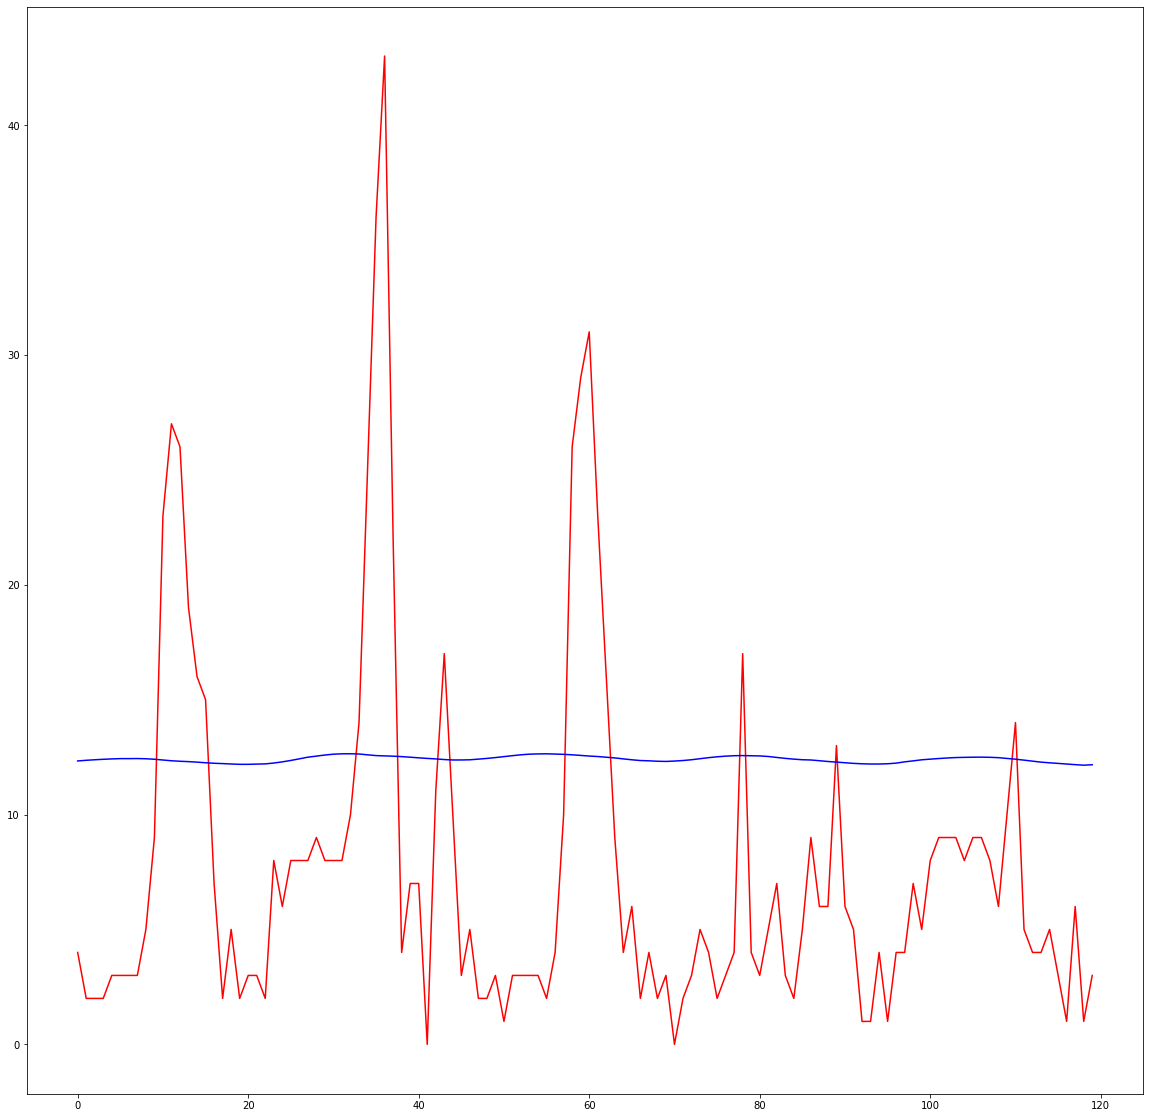

In [31]:
plt.figure(figsize=(20, 20))
plt.plot(y_test[:, p[2], 0], c='red')
plt.plot(y_pred[:, p[2], 0], c='blue')

In [27]:
stations["name"].unique()

array(['Dewajtis - UKSW', 'Metro Młociny', 'Marymoncka - Dewajtis',
       'Metro Wawrzyszew', 'Górskiego - Szpitalna', 'Metro Stare Bielany',
       'Bielany-Ratusz', 'Metro Słodowiec', 'Potocka – OSiR Żoliborz',
       'Gwiaździsta - Promyka', 'al. Reymonta - Conrada',
       'Broniewskiego - Perzyńskiego', 'Metro Marymont',
       'Metro Plac Wilsona', 'Broniewskiego - Włościańska',
       'Broniewskiego - Krasińskiego', 'Wybrzeże Gdyńskie - KS Spójnia',
       'Plac Grunwaldzki', 'Zajączka - Bitwy Pod Rokitną',
       'Plac Inwalidów', 'Pętla Stare Bemowo', 'Pętla Nowe Bemowo',
       'Obrońców Tobruku - Pieniążka', 'Powązkowska - Krasińskiego',
       'Powązkowska - Plac Niemena', 'Przasnyska - Rydygiera',
       'Powązkowska - Burakowska', 'Metro Dworzec Gdański',
       'Powstańców Śląskich - Radiowa', 'Obozowa - Ciołka',
       'al. Prymasa Tysiąclecia - Kasprzaka', 'Obozowa - Radziwie',
       'al. Jana Pawła II - Stawki', 'Stawki - Dubois',
       'Andersa - Muranowska', 'San